<a href="https://colab.research.google.com/github/elliwadler/image_classification/blob/main/cat_dog_classification_classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bildklassifikation - 😺 vs. 🐶**

## Bibliotheken importieren


In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import zipfile
import gdown
import random
import shutil
import seaborn as sns
import pandas as pd
from PIL import Image as image_p
import os

## Ressourcen laden

Der Code lädt einen **Datensatz** mit Hund- und Katzenbildern als ZIP-Datei herunter und extrahiert ihn in zwei Ordner, "train" und "validation".

In [2]:
# Download the dataset zip file
url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
filename = "cats_and_dogs_filtered.zip"
urllib.request.urlretrieve(url, filename)

# Extract the zip file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
print("Number of images in train/cats:",  len(os.listdir('cats_and_dogs_filtered/train/cats')))
print("Number of images in train/dogs:",  len(os.listdir('cats_and_dogs_filtered/train/dogs')))

print("Number of images in validation/cats:",  len(os.listdir('cats_and_dogs_filtered/validation/cats')))
print("Number of images in validation/dogs:",  len(os.listdir('cats_and_dogs_filtered/validation/dogs')))

Number of images in train/cats: 1000
Number of images in train/dogs: 1000
Number of images in validation/cats: 500
Number of images in validation/dogs: 500


## Vorbereitung der Daten 

Um die Daten für das Modell Vorzubereiten wird die **ImageDataGenerator-Klasse** aus der Keras-API verwendet. In dieser werden Datenaugmentierungstechniken wie Drehung, Zuschneiden oder Spiegeln definiert um sie auf die Bilder anzuwenden.

Anschließend wird mit der **flow_from_directory()-Methode** ein **Generator-Objekt** erzeugt, das später an das Modell übergeben wird. Dabei werden unter anderem das Verzeichnis aus dem die Bilder geladen werden, die Bildgröße, die Batch-Größe und die Label-Art (in diesem Fall binary, also entweder Hund oder Katze) definiert.

Wir erzeugen hier 3 Generator-Objekte. Eins für das Training des Modell, eins für die Validierung während des Trainings und ein Datensatz wird für anschließende Tests vorbehalten.


In [44]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    # 10% of the training images will be used for validation
    validation_split=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    
)

train_generator = train_datagen.flow_from_directory(
        'cats_and_dogs_filtered/train',
        target_size=(150, 150),
        batch_size=20,
        subset='training',
        class_mode='categorical',
        shuffle=True)

validation_generator = train_datagen.flow_from_directory(
        'cats_and_dogs_filtered/train',
        target_size=(150, 150),
        batch_size=20,
        subset='validation',
        class_mode='categorical',
        shuffle=True)

# Images for Testing
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = datagen.flow_from_directory(
        'cats_and_dogs_filtered/validation',
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [45]:
print(train_generator.labels)

[0 0 0 ... 1 1 1]


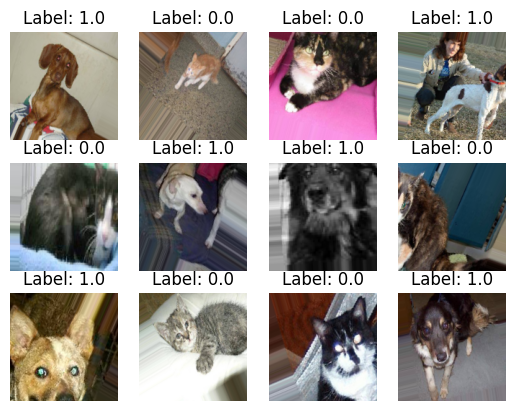

In [ ]:
#Print some pictures from the train_generator
images, labels = next(train_generator)
fig, axes = plt.subplots(3, 4)
axes = axes.ravel()
for i in range(12):
    axes[i].imshow(images[i])
    axes[i].axis('off')
    axes[i].set_title('Label: {}'.format(labels[i]))
plt.show()

## *Beispiel Augementierung eines Bildes*

Hier wird die ImageDataGenerator-Instanz **train_datagen** verwendet um die Argumentation eines Beispielbildes zu veranschaulichen. 





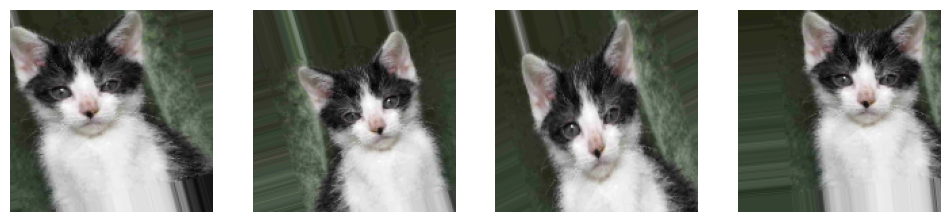

In [ ]:
# get all files from the train/cat directory
fnames = [os.path.join('cats_and_dogs_filtered/train/cats', fname) for
  fname in os.listdir('cats_and_dogs_filtered/train/cats')]

# get one picture
img_path = fnames[6]
img = load_img(img_path, target_size=(150, 150))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

# plot the result - use subplot to display them next to each other
fig, axs = plt.subplots(1, 4, figsize=(12, 12))
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    axs[i].imshow(array_to_img(batch[0]))
    axs[i].axis('off')
    i += 1
    if i >= 4:
        break
plt.show()

## Definition des Modells

In Keras ist das **Sequential-Modell** eine Möglichkeit, um Schichten eines neuronalen Netzwerks aufeinander zu stapeln. Das bedeutet, dass die Ausgabe einer Schicht direkt an die nächste Schicht weitergegeben wird. Ein Sequential-Modell ist somit eine lineare Schichtfolge, bei der jede Schicht genau eine Eingabe und eine Ausgabe hat. Dies ist die einfachste Art, ein neuronales Netzwerk in Keras zu definieren. Die einzelnen Schichtarten werden in der **README ausführlich** erklärt!

Im nächsten Schritt wird der **Kompilierungsschritt** des Modells konfiguriert. Auf die einzelnen Werte wird wieder in der README eingeganen. 




In [46]:
#cats_dogs_classifier_75%_20230504
'''model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.15),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(2, activation='softmax')
])'''

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.15),
    Flatten(),
    Dropout(0.15),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')
])


model.compile(loss='binary_crossentropy',
              optimizer= tf.optimizers.Adam(learning_rate=0.001),
              metrics=['acc'])

# shows each layer
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 74, 74, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                      

## Trainieren des Modells

In diesem Code-Abschnitt wird das Modell mit den Trainingsdaten **trainiert** und dabei direkt eine **Validierung** anhand der Validierungsdaten durchgeführt. Die Trainingsdaten und die Validierungsdaten wurden zuvor als Daten-Generator mit der Klasse **ImageDataGenerator** erstellt und werden nun als **Argumente** an die fit-Methode des Modells übergeben.

**Parameter:**

**steps_per_epoch**: gibt die Anzahl der Schritte pro Epoche an, d.h. die Anzahl der Batches, die pro Epoche durchlaufen werden sollen. 

**epochs:** gibt die Anzahl der Epochen an, die das Modell trainiert werden soll. 

**validation_steps:**  Anzahl der Schritte (Batches), die pro Validierungs-Epoche durchlaufen werden sollen. 

Die fit-Methode führt das Training des Modells durch und gibt ein **history-Objekt zurück**, das die Informationen über die Trainingsgenauigkeit, Trainingsverlust, Validierungsgenauigkeit und Validierungsverlust in jeder Epoche enthält.

**Da das Trainieren das Modells den heutigen Zeitraum sprengen würde werden wir das ein zuvor von mir trainiertes Modell in den weiteren Schritten verwenden**!

In [47]:

history = model.fit(
      train_generator,
      steps_per_epoch=len(train_generator),
      epochs=50,
      validation_data=validation_generator,
      validation_steps=len(validation_generator),
      shuffle = True)


# load pretrained model
#gdown.download_folder('https://drive.google.com/drive/folders/1MPrC5o7rI8_EYEZ6TLOWsWes44JKk-aD?usp=sharing')

Epoch 1/50
90/90 [==============================] - 20s 194ms/step - loss: 0.7058 - acc: 0.5350 - val_loss: 0.6903 - val_acc: 0.5800
Epoch 2/50
90/90 [==============================] - 16s 181ms/step - loss: 0.6796 - acc: 0.5661 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/50
90/90 [==============================] - 18s 195ms/step - loss: 0.6670 - acc: 0.5850 - val_loss: 0.6887 - val_acc: 0.5200
Epoch 4/50
90/90 [==============================] - 18s 199ms/step - loss: 0.6642 - acc: 0.6039 - val_loss: 0.6851 - val_acc: 0.5350
Epoch 5/50
90/90 [==============================] - 16s 182ms/step - loss: 0.6415 - acc: 0.6361 - val_loss: 0.6846 - val_acc: 0.5550
Epoch 6/50
90/90 [==============================] - 16s 181ms/step - loss: 0.6379 - acc: 0.6228 - val_loss: 0.6157 - val_acc: 0.6750
Epoch 7/50
90/90 [==============================] - 16s 180ms/step - loss: 0.6644 - acc: 0.6028 - val_loss: 0.6636 - val_acc: 0.6250
Epoch 8/50
90/90 [==============================] - 16s 181ms/step - 

In [ ]:
model = tf.keras.models.load_model('Assets_Modell/cats_dogs_classifier_82%.h5')

# Validierung des Modells

## Plot Validation accurary  & -loss

Zuerst wird die CSV-Datei eingelesen, die die Trainingshistorie des heruntergeladenen Modells enthält. Die CSV-Datei enthält Spalten für den Trainingsverlust, den Validierungsverlust, die Trainingsgenauigkeit und die Validierungsgenauigkeit bei jedem Epoch während des Trainings.

test_loss, test_acc = model.evaluate(test_generator, steps=50): Diese Zeile bewertet die Leistung des trainierten Modells anhand eines Testdatensatzes.  Die Methode evaluate() gibt den Testverlust und die Testgenauigkeit des Modells zurück. 



50/50 [==============================] - 5s 98ms/step - loss: 0.5134 - acc: 0.7450
Test accuracy: 0.7450000047683716
Test loss: 0.5133999586105347


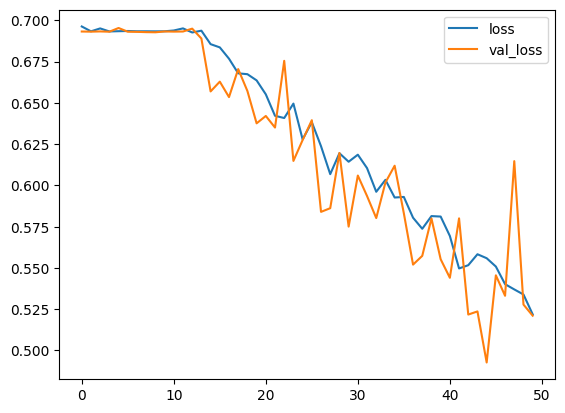

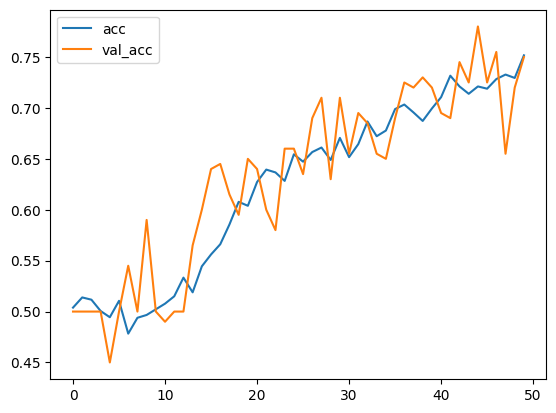

In [25]:
#history_df = pd.read_csv('Assets_Modell/train_history_82%.csv')

history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['acc', 'val_acc']].plot()


test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

## Confusion Matrix

In [13]:
# Get the predicted classes for the test data
y_pred_prob = model.predict(test_generator)
y_pred = np.round(y_pred_prob)

# Get the true classes for the test data
#y_true = test_generator.labels

# Create the confusion matrix
#cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
#cm_display = ConfusionMatrixDisplay(cm, display_labels=['cat', 'dog']).plot()

50/50 [==============================] - 5s 86ms/step


In [51]:
y_true = train_generator.labels
#images, labels = next(test_generator)
print((y_true))

[0 0 0 ... 1 1 1]


In [54]:
y_pred_prob = model.predict(test_generator)
y_pred = np.round(y_pred_prob)
y_pred_1 = np.asarray([np.asarray(np.argmax((i))) for i in y_pred])

print(y_pred_1)

50/50 [==============================] - 6s 115ms/step
[0 0 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 0 0 0 1 0 0
 0 1 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 1
 0 0 1 0 0 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 0 1 0 0 0 0 1 1 1 1
 1 0 1 0 0 0 1 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 0 0 0 0 1
 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0
 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0
 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0
 0 0 0 1 0 0 1 0 1 1 1 1 1 0 0 1 1 1 0 0 1 1 0 0 0 0 0 1 0 1 1 1 1 1 0 1 1
 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1
 1 1 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 1 1 1 1
 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 1 0 0 0 1 0 0 1 1 1 0
 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 1 1 1 0
 0 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 1 0 1 0 1 

In [53]:
cm = confusion_matrix(y_true, y_pred_1)

ValueError: ignored

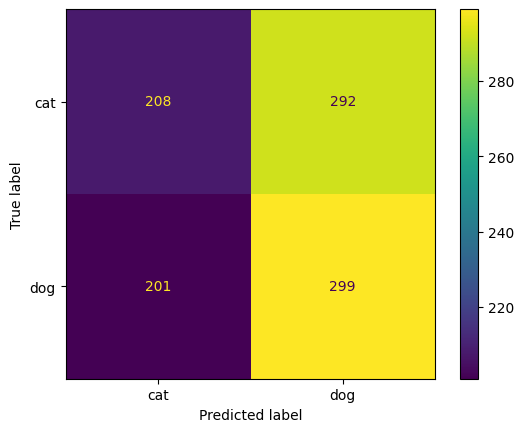

In [40]:
cm_display = ConfusionMatrixDisplay(cm, display_labels=['cat', 'dog']).plot()

1/1 [==============================] - 0s 28ms/step


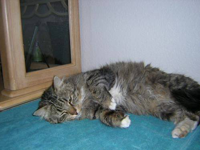

0.9663224
Based on my expert analysis, that appears to be a  DOG.


In [ ]:
from tensorflow.keras.preprocessing import image

# Load the saved model
#model = tf.keras.models.load_model('Assets_Modell/cats_dogs_classifier_82%.h5')

# Load the image and resize to the target size

#img_path = 'cats_and_dogs_filtered/validation/dogs/dog.2020.jpg'
#img_path = 'cats_and_dogs_filtered/validation/dogs/dog.2013.jpg'
#img_path = 'cats_and_dogs_filtered/validation/cats/cat.2019.jpg'
img_path = 'cats_and_dogs_filtered/validation/cats/cat.2119.jpg'
img = image.load_img(img_path, target_size=(150, 150))

# Convert the image to a numpy array and normalize
img_array = image.img_to_array(img)
img_array /= 255.

# Expand the dimensions of the image array to match the model input shape
img_array = np.expand_dims(img_array, axis=0)

# Predict the class of the image
pred = model.predict(img_array)
pred_probability = pred[0][0]

# Print the image
image = image_p.open(img_path)
width, height = image.size
new_width = 200
new_height = int(height * (new_width / width))
resized_image = image.resize((new_width, new_height))
resized_image.show()
print(pred[0][0])
if pred[0][0] > 0.5:
    print("Based on my expert analysis, that appears to be a \033[95m\033[1m DOG\033[0m.")
else:
    print("Meow, that's most definitely a \033[95m\033[1m CAT\033[0m (or a Chihuahua)!")

## Heatmap

Eine Heatmap ist eine visuelle Darstellung von Daten, die in Form einer Farbskala dargestellt werden. 
Sie sind nützlich um bestimmte Muster und Zusammenhänge in den Daten zu erkennen. Zum Beispiel kann man sie nutzen, um zu sehen, welche Bereiche in einem Bild am meisten Aktivität aufweisen, also für das Model am relevantesten für die Klassifizierung sind. 


In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
from cv2 import hconcat, imread, applyColorMap, resize, COLORMAP_JET, waitKey, destroyAllWindows, vconcat
from google.colab.patches import cv2_imshow 

### Funktion um Heatmap zu kreieren

In [ ]:
def create_heatmap(orig):

  # define intensity of colormap and size of pictures
  intensity=0.5
  res= 150
  img = load_img(orig, target_size=(150, 150))

  # Convert the image to a numpy array and normalize
  img_array = img_to_array(img)
  img_array /= 255.

  # Expand the dimensions of the image array to match the model input shape
  img_array = np.expand_dims(img_array, axis=0)

  # Predict the class of the image
  pred = model.predict(img_array, verbose=0)
  pred_probability = pred[0][0]
  if pred_probability > 0.5:
    print('dog', end='; ')
  else:
    print('cat', end='; ')

  # Magic - visualize the regions of the image that are most important for the model
  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('conv2d_4')
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(img_array)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
      
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape((52, 42)) #15 15

  img = imread(orig)

  heatmap = resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = applyColorMap(np.uint8(255*heatmap), COLORMAP_JET)
  # place Heatmap above picture
  img = heatmap * intensity + img
  return resize(img, (res, res))

## Test einiger Bilder


In [ ]:
# define images
images = [
    'cats_and_dogs_filtered/validation/cats/cat.2001.jpg',
    'cats_and_dogs_filtered/validation/cats/cat.2102.jpg',
    'cats_and_dogs_filtered/validation/cats/cat.2103.jpg',
    'cats_and_dogs_filtered/validation/cats/cat.2104.jpg',
    'cats_and_dogs_filtered/validation/cats/cat.2105.jpg',
    'cats_and_dogs_filtered/validation/cats/cat.2001.jpg',
    'cats_and_dogs_filtered/validation/dogs/dog.2001.jpg',
    'cats_and_dogs_filtered/validation/dogs/dog.2102.jpg',
    'cats_and_dogs_filtered/validation/dogs/dog.2103.jpg',
    'cats_and_dogs_filtered/validation/dogs/dog.2104.jpg',
    'cats_and_dogs_filtered/validation/dogs/dog.2167.jpg',
    'cats_and_dogs_filtered/validation/dogs/dog.2197.jpg'
]

heatmap_images = []

for image in images:
    heatmap_images.append(create_heatmap(image))

# Print results
result1 = hconcat(heatmap_images[:6])
result2 = hconcat(heatmap_images[6:])
result = vconcat([result1, result2])

cv2_imshow(result)
waitKey(0)
destroyAllWindows()

dog; 

ValueError: ignored

## Nur für mich - speichern und upload des Modells !!

In [9]:
import pandas as pd

history_df = pd.DataFrame(model.history.history)
history_df.to_csv('train_history_categorical_75%_20230504.csv', index=False)
model.save('cats_dogs_classifier_75%_20230504.h5')

In [11]:
from google.colab import drive
import shutil
import zipfile

drive.mount('/content/drive')
with zipfile.ZipFile('model.zip', 'w',
                     compression=zipfile.ZIP_DEFLATED,
                     compresslevel=9) as zf:
    zf.write('/content/cats_dogs_classifier_75%_20230504.h5', arcname='cats_dogs_classifier_75%_20230504.h5')

shutil.copy("/content/cats_dogs_classifier_75%_20230504.h5","/content/drive/MyDrive/MachineLearning")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/MachineLearning'

In [ ]:
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 14.9 MB/s eta 0:00:00


In [ ]:
print(1)

In [ ]:
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers

def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=150, step=32),
                                  kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                                  activation='relu', input_shape=(150, 150, 3)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=150, step=32),
                                  kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
                                  activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Conv2D(filters=hp.Int('conv_3_filter', min_value=32, max_value=150, step=32),
                                  kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),
                                  activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(keras.layers.Conv2D(filters=hp.Int('conv_4_filter', min_value=32, max_value=150, step=32),
                                  kernel_size=hp.Choice('conv_4_kernel', values=[3, 5]),
                                  activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)
    model.add(keras.layers.Dropout(rate=hp_dropout))

    model.add(keras.layers.Flatten())

    hp_dropout1 = hp.Float('dropout1', min_value=0.0, max_value=0.5, step=0.1)
    model.add(keras.layers.Dropout(rate=hp_dropout1))

    model.add(keras.layers.Dense(units=hp.Int('dense_1_units', min_value=32, max_value=512, step=32),
                                  activation='relu'))
    
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
    return model

In [ ]:
tuner = keras_tuner.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='round_3'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(train_generator, validation_data=validation_generator, callbacks=[stop_early])

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(150, 150, 3))
best_model.summary()